In [1]:
from pyspark.sql import SparkSession
import os
from search import Search
from plotting import Plotting


Bad key "text.kerning_factor" on line 4 in
E:\Users\Sam\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def read(spark):
    datasets = {}
    for dataset in os.listdir("./ml-latest-small"):
        data = spark.read.option("header", True).format("csv").load(os.path.join(os.getcwd(),"ml-latest-small",dataset))
        datasets[dataset.split('.')[0]]=data
    return datasets

In [3]:
spark = SparkSession.builder.master("local").appName("Movies").config("conf-key", "conf-value").getOrCreate()
datasets = read(spark)

In [4]:
plotting = Plotting(datasets, spark)
search = Search(datasets, spark)

Search user by id, show the number of movies/genre that he/she has watched

In [5]:
search.search_user_movies('1')

232

In [6]:
search.search_user_genre('1').show()

+---------+--------+
|   genres|count(1)|
+---------+--------+
|    Crime|      45|
|  Romance|      26|
| Thriller|      55|
|Adventure|      85|
|    Drama|      68|
|      War|      22|
|  Fantasy|      47|
|  Mystery|      18|
|  Musical|      22|
|Animation|      29|
|Film-Noir|       1|
|   Horror|      17|
|  Western|       7|
|   Comedy|      83|
| Children|      42|
|   Action|      90|
|   Sci-Fi|      40|
+---------+--------+



Given a list of users, search all movies watched by each user

In [7]:
[i for i in search.search_users_movies(["1","2","3"])]

[232, 29, 39]

Search movie by id/title, show the average rating, the number of users that have
watched the movie

In [5]:
search.search_movie(id="1").show()

+-------+-----------------+--------+----------------+
|movieId|      avg(rating)|count(1)|           title|
+-------+-----------------+--------+----------------+
|      1|3.813953488372093|     215|Toy Story (1995)|
+-------+-----------------+--------+----------------+



In [6]:
search.search_movie(name="Toy Story").show()

+-------+-----------------+--------+------------------+
|movieId|      avg(rating)|count(1)|             title|
+-------+-----------------+--------+------------------+
|   3114|3.711340206185567|      97|Toy Story 2 (1999)|
|      1|3.813953488372093|     215|  Toy Story (1995)|
|  78499|3.981818181818182|      55|Toy Story 3 (2010)|
+-------+-----------------+--------+------------------+



Search genre, show all movies in that genre

In [15]:
search.search_genre("Action").show(10,False)

+-------+-----------------------------------------+---------------------------------+
|movieId|title                                    |genres                           |
+-------+-----------------------------------------+---------------------------------+
|485    |Last Action Hero (1993)                  |Action|Adventure|Comedy|Fantasy  |
|2433   |Civil Action, A (1998)                   |Drama                            |
|3710   |Action Jackson (1988)                    |Action|Comedy|Crime|Thriller     |
|3766   |Missing in Action (1984)                 |Action|War                       |
|3767   |Missing in Action 2: The Beginning (1985)|Action|War                       |
|3768   |Braddock: Missing in Action III (1988)   |Action|War                       |
|6946   |Looney Tunes: Back in Action (2003)      |Action|Animation|Children|Fantasy|
|32058  |Class Action (1991)                      |Drama                            |
+-------+-----------------------------------------+---

Given a list of genres, search all movies belonging to each genre

In [ ]:
#TODO

Search movies by year

In [16]:
search.search_movie_year("1995").show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

List the top n movies with highest rating, ordered by the rating

In [ ]:
#TODO

List the top n movies with the highest number of watches, ordered by the number of
watches

In [ ]:
#TODO

Find the favourite genre of a given user, or group of users. Consider and justify how
you will define ‘favourite’.

In [5]:
search.search_user_favourites("1").show(10,False)

+---------+------------------+
|genres   |score             |
+---------+------------------+
|Action   |4.322222222222222 |
|Adventure|4.142494117647059 |
|Comedy   |3.9392168674698795|
|Drama    |3.410647058823529 |
|Thriller |2.516290909090909 |
|Fantasy  |2.222             |
|Crime    |2.151644444444444 |
|Children |2.096452380952381 |
|Sci-Fi   |1.85055           |
|Animation|1.4772413793103447|
+---------+------------------+
only showing top 10 rows



Compare the movie tastes of two users. Consider and justify how you will compare
and present the data.

In [ ]:
#TODO

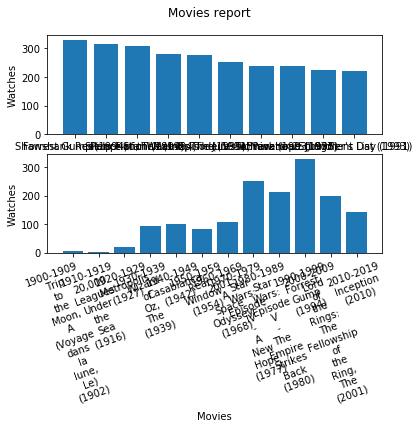

In [6]:
plotting.gen_movies_report()

E:\Spark\plotting.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_other = pd.concat([df_other, new_row])
E:\Spark\plotting.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_other = pd.concat([df_other, new_row])


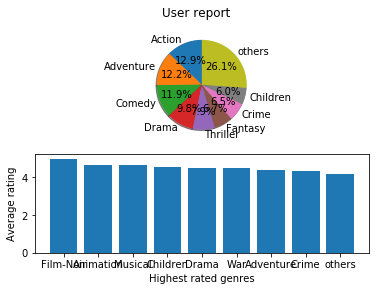

In [7]:
plotting.gen_user_report("1")